## Построение графа друзей друзей из вк. И использование метода центрального посредничества
В ячейке ниже приведен упрощенный запуск программы. Для экономии времени не происходит никаких запросов к vk_ip и построение графа друзей. Здесь происходит простое считывание графа из заранее заготовленного текстого файла, он отрисовывается, находится узел с наибольшим коэфицентом центральности и выводится на экран его vk_id.

При отрисовки графа учитывается то, насколько большой коэффициент центральности у каждого узла, и в зависимости от этого, задается интенсивность цвета.

Для простой проверки алгоритма можете запустить упрощенную программу преведенную в ячейке ниже:


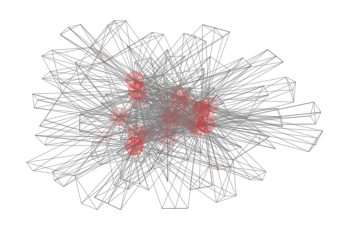

id: 44907648 , coefficient centrality = 0.13938915929929174


In [65]:
from vk_api import *
import networkx
from networkx import *
from matplotlib import pylab as pl

#считываем заранее записанный граф друзей друзей
graph = nx.read_gml("result_graph.txt")

#Строим график
pl.figure()
pl.axis('off')

fig = pl.figure(1)
pos=nx.spring_layout(mygraph)

li = list(betweenness_centrality(mygraph).values())
my_new_list = [i * 2 for i in li]
my_new_list

draw_networkx_nodes(mygraph, pos,alpha = my_new_list, node_color ='#FF0000')
draw_networkx_edges(mygraph, pos, alpha=0.4, edge_color='gray')

pl.show()

#Вывод id человека с наивысшим коэффицентом центральности
central = betweenness_centrality(graph)
max_value = max(central.values())
for i in central:
    if central[i]==max_value:
        print('id:',i,', coefficient centrality =',max_value)


Ниже приведена вся программа, от подключения к vk_ip и запросам к id людей, до составления графа нужной лубины и отсеивания ненужных людей.

In [66]:
from vk_api import *
import networkx
from networkx import *
from matplotlib import pylab as pl

DEEP = 2 #задает глубину будущего графа
FRIENDS_LIMIT = 30


Для подключения к ВК, необходимо сначала авторизоваться. Введите  свои данные вместо <b> 'login',  'password' </b>

In [2]:
#Авторизация в ВК
login, password = 'login', 'password'
vk_session = vk_api.VkApi(login, password)
try:
    vk_session.auth(token_only=True)
except vk_api.AuthError as error_msg:
    print(error_msg)
vk = vk_session.get_api()

Считываем исходные данные, по которым будем в дальнейшем искать общих друзей

In [3]:
#Считывание первичных пользователей
file = open('id_group.txt')
data_id = file.read().split('\n')
data_id = list(map(int,data_id))
file.close()

### Построение графа друзей-друзей. 
Для быстроты работы алгоритма советуем задавать глубину обхода людей равную 2.

In [ ]:
#init графа, создание лога ошибок
G = nx.Graph()
ER_LOG = open('ERROR_LOG.txt','w')
#пользователи представлены в виде словаря: ключ - пользователь. значения - его друзья
users = {}
#первый цикл добавит друзей в 1-ом приближении, тут нет ограничения на кол-во друзей
for user in data_id:
    G.add_node(user)
    try:
        users[user] = vk.friends.get(user_id=user,count=20)['items']
        for friend in users[user]:
                G.add_node(friend)
                G.add_edge(user,friend)
    except vk_api.ApiError as error_msg:
        ER_LOG.write('user_id:' + str(user) + str(error_msg) + '\n')
k = 1
#Второй цикл будет добавлять друзей друзей и т.д. до нужной глубины
#Использую while т.к. потом добавлю функцию, которая будет проверять, может уже построились все необходимые связи
#и дальше искать друзей не нужно
while k <= DEEP:
    '''Пользователи, которые уже добавлены кому-то в друзья, но для них самих список друзей ещё не получен
    ищутся как разность между множеством ключей и множеством значений. Это сразу помогает избавится и от повторений
    и от зацикливания и от повторной обработки людей, которые уже добавлены'''
    new_users = set([item for sublist in users.values() for item in sublist]).difference(users.keys())
    for user in new_users:
        G.add_node(user)
        try:
            users[user] = vk.friends.get(user_id=user,count=FRIENDS_LIMIT)['items']
            for friend in users[user]:
                G.add_node(friend)
                G.add_edge(user,friend)
        except vk_api.ApiError as error_msg:
            ER_LOG.write('user_id:' + str(user) + str(error_msg) + '\n')
    k += 1
ER_LOG.close()
#кол-во пользователей, для которых был получен список друзей
print(len(users.keys()))

### Обработка графа друзей, чтобы отсеить людей, у которых нет никаких связей с исходными данными

In [69]:
#nx.shortest_path(G, 0, 3)
'''Дальше будет обработка графа с помощью функции кратчайшего пути, все лишние элементы будут выкинуты'''
shortest_path=[]
PATH_ERROR_LOG=open('PATH_ERROR_LOG.txt','w')
#Формируется list, содержащий кратчайшие пути. Путь представлен как набор входящих в него вершин.
for i in data_id:
    for j in data_id[data_id.index(i) + 1:]:
        try:
            shortest_path.append(nx.shortest_path(G,i,j))
        except nx.NetworkXNoPath as error_msg:
            PATH_ERROR_LOG.write('node1:' + str(i) + 'node2:' + str(j) + str(error_msg))
result_graph = nx.Graph()
#Далее из основного графа формируется результирующий граф, содержащий лишь те вершины, которые 
#содержаться в кратчайших путях между исходными пользователями
for path in shortest_path:
    for node1 in path:
        result_graph.add_node(node1)
        for node2 in path[path.index(node1)+1:]:
            result_graph.add_node(node2)
            result_graph.add_edge(node1,node2)
nx.write_gml(result_graph, "result_graph.txt")

NameError: name 'data_id' is not defined

In [49]:
mygraph = nx.read_gml("result_graph.txt")

### Рисование графа
При отрисовки графа учитывается то, насколько большой коэффициент центральности у каждого узла, и в зависимости от этого, задается интенсивность цвета.

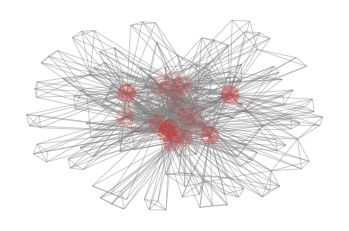

In [67]:
#nx.draw(mygraph)
pl.figure()

pl.axis('off')
fig = pl.figure(1)

pos=nx.spring_layout(mygraph)
li = betweenness_centrality(mygraph).values()
li=list(li)
my_new_list = [i * 2 for i in li]
my_new_list


draw_networkx_nodes(mygraph,pos,alpha=my_new_list,node_color ='#FF0000')
draw_networkx_edges(mygraph, pos,alpha=0.4,edge_color='gray')
#draw_networkx_labels(G, pos)

pl.show()

### Вывод человека, который всех нас связывает

In [22]:
my_new_list
central = betweenness_centrality(mygraph)
max_value = max(central.values())
for i in central:
    if central[i]==max_value:
        print('id:',i,', cantraliyu =',max_value)


id: 44907648 , cantraliyu = 0.13938915929929174
